In [1]:
import os
import monai
import torch
import torch.nn as nn
import torch.optim as optim
from monai.networks.nets import UNet
from monai.data import DataLoader, CacheDataset, ImageDataset, Dataset, image_reader
from monai.data.utils import pad_list_data_collate
from monai.transforms import Compose, ScaleIntensity, ToTensor,LoadImaged, ScaleIntensityd, ToTensord,EnsureChannelFirstd
import SimpleITK as sitk
from monai.data.image_reader import ITKReader
from monai.losses import DiceLoss
from monai.metrics import MSEMetric
import dataset
from dataset import PelvisDataset
import numpy as np
import sklearn
from monai.metrics import compute_hausdorff_distance
from UNETR import UNETR



In [2]:
#plot 
import matplotlib.pyplot as plt
def plot_results(inputs,targets,outputs):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    depth_slice = inputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_target = targets[:, :,22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_outputs = outputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension

    image_array = depth_slice[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_target = depth_slice_target[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_outputs = depth_slice_outputs[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch

    axes[0].imshow(image_array[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[0].set_title("inputs")
    axes[0].axis('off')  # Turn off axis labels


    axes[1].imshow(image_array_target[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[1].set_title("target")
    axes[1].axis('off')  # Turn off axis labels


    axes[2].imshow(image_array_outputs[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[2].set_title("output")
    axes[2].axis('off')  # Turn off axis labels

    plt.show()

# DATASET

Train dataset and dataloader

In [3]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/train_files"
input_dim = (194,148,105)
n_labels= 2

train_dataset = PelvisDataset(root_dir,input_dim, n_labels)

train_dataloader = DataLoader(train_dataset, batch_size =5)

validation dataloader

In [3]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/val_files"
input_dim = (194,148,105)
n_labels= 2
val_dataset = PelvisDataset(root_dir,input_dim, n_labels, transform=None)

val_dataloader = DataLoader(val_dataset, batch_size =5)

test dataloader

In [5]:
root_dir ="/home/paulagmtz/TFM_PAULA_24/DATA_TFM/test_files"
input_dim = (194,148,105)
n_labels= 2
test_dataset = PelvisDataset(root_dir,input_dim, n_labels, transform=None)

test_dataloader = DataLoader(test_dataset, batch_size =5)

# UNET


In [6]:
import torch
torch.cuda.empty_cache()

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128,256,512), 
    strides=(2,2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)

In [11]:
# loss_function = nn.BCELoss()
loss_function = DiceLoss(sigmoid=True, squared_pred=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


Plot function

In [15]:
#plot 
import matplotlib.pyplot as plt
def plot_results(inputs,targets,outputs):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    depth_slice = inputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_target = targets[:, :,22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_outputs = outputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension

    image_array = depth_slice[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_target = depth_slice_target[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_outputs = depth_slice_outputs[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch

    axes[0].imshow(image_array[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[0].set_title("inputs")
    axes[0].axis('off')  # Turn off axis labels


    axes[1].imshow(image_array_target[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[1].set_title("target")
    axes[1].axis('off')  # Turn off axis labels


    axes[2].imshow(image_array_outputs[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[2].set_title("output")
    axes[2].axis('off')  # Turn off axis labels

    plt.show()

Train model

In [12]:
num_epochs = 200
loss_evolution = []

for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # plot_results(inputs,targets,outputs)
    loss_evolution.append(loss)
    plot_results(inputs,targets,outputs)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")

print("Training complete.")


RuntimeError: The size of tensor a (910) must match the size of tensor b (648) at non-singleton dimension 1

Loss evolution

Save model

In [ ]:
# Save the model's state_dict to a file
# 'model.pth'
torch.save(model.state_dict(), "/home/paulagmtz/TFM_PAULA_24/model_2.pth")


Load model

In [18]:
# from monai.model import Unet
# # Create an instance of your model (ensure that it has the same architecture)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_new = UNet(
    spatial_dims=3 ,
    in_channels=1,
    out_channels=1,
    channels=(64,128,256,512), 
    strides=(2,2,2),
    # num_res_units=2,
    # norm=Norm.BATCH,    
).to(device)
# Load the saved model parameters
model_new.load_state_dict(torch.load("/home/paulagmtz/TFM_PAULA_24/model.pth"))

# Set the model to evaluation mode
model_new.eval()


UNet(
  (model): Sequential(
    (0): Convolution(
      (conv): Conv3d(1, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
      (adn): ADN(
        (N): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (D): Dropout(p=0.0, inplace=False)
        (A): PReLU(num_parameters=1)
      )
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): Convolution(
          (conv): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (1): SkipConnection(
          (submodule): Sequential(
            (0): Convolution(
              (conv): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
              (adn): ADN(
                (N): 

vuelvo a obtener lo que em salia del entrenamiento

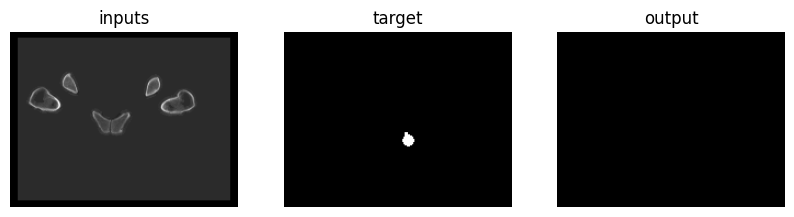

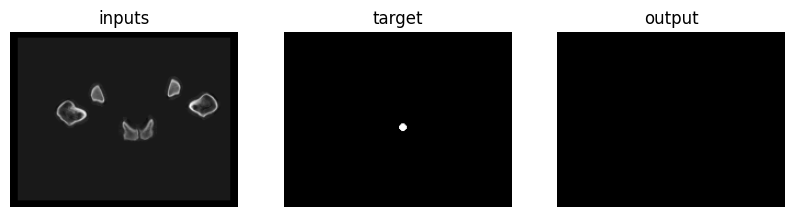

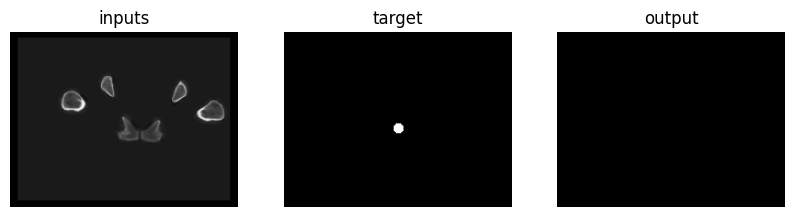

KeyboardInterrupt: 

In [21]:
# vuelvo a obtener lo que em salia del entrenamiento

for batch in train_dataloader:  # Use the appropriate DataLoader
    inputs, targets = batch[0].to(device), batch[1].to(device)
    # print(inputs.shape)
    # print(targets.shape)
    with torch.no_grad():
        outputs = model_new(inputs)
        out = nn.functional.softmax(outputs, dim = 1)
        
        plot_results(inputs,targets,out)

Evaluate the model

arr 0.97125083
norma 1.0
arr 0.9948349
norma 1.0
out_orev tensor([[[[[ -9.4483,  -8.8304, -10.7632,  ..., -21.7419, -28.5882,
            -19.2474],
           [-12.1140, -10.8118, -12.7998,  ..., -25.8689, -32.5457,
            -22.2512],
           [-13.3954, -14.9682, -15.2107,  ..., -25.2371, -31.6361,
            -24.2996],
           ...,
           [-16.6196, -14.5433, -16.7981,  ..., -23.9073, -30.7018,
            -18.1010],
           [-19.7688, -21.9387, -19.4139,  ..., -27.7306, -33.5107,
            -22.2480],
           [-13.5699, -14.5353, -13.6271,  ..., -18.8329, -20.8579,
            -12.3879]],

          [[-15.3998, -16.7875, -19.7571,  ..., -27.4522, -35.4336,
            -19.6119],
           [-17.7334, -21.4267, -19.3981,  ..., -31.8969, -31.0610,
            -20.4822],
           [-16.6672, -16.7557, -20.3198,  ..., -25.2069, -29.8345,
            -16.6974],
           ...,
           [-17.7238, -19.5916, -17.8387,  ..., -22.2912, -24.8248,
            -18.4695]

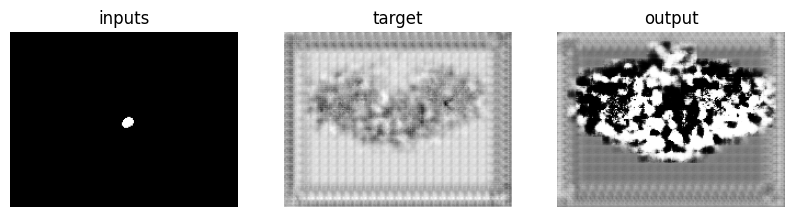

arr 0.9631602
norma 1.0
arr 0.99957824
norma 1.0
out_orev tensor([[[[[-10.3317,  -9.8908, -11.2899,  ..., -25.8222, -32.2628,
            -20.7377],
           [-14.1629, -12.8384, -14.2801,  ..., -30.4046, -37.2833,
            -25.0715],
           [-14.6713, -16.8059, -16.3711,  ..., -29.0334, -34.9914,
            -26.5892],
           ...,
           [-19.7767, -18.0049, -20.6248,  ..., -28.4848, -35.2576,
            -20.4233],
           [-22.2966, -25.1601, -22.5914,  ..., -31.9011, -37.1040,
            -24.2309],
           [-15.5671, -16.3912, -15.8444,  ..., -21.0864, -23.2243,
            -13.6139]],

          [[-18.7206, -18.6889, -22.3697,  ..., -33.0191, -41.8674,
            -22.8390],
           [-19.1666, -24.2903, -21.1411,  ..., -37.1527, -35.2671,
            -24.0178],
           [-20.3642, -19.8320, -24.4076,  ..., -29.5026, -35.0871,
            -19.6347],
           ...,
           [-20.6490, -23.2737, -21.7593,  ..., -25.6930, -27.7245,
            -21.3814]

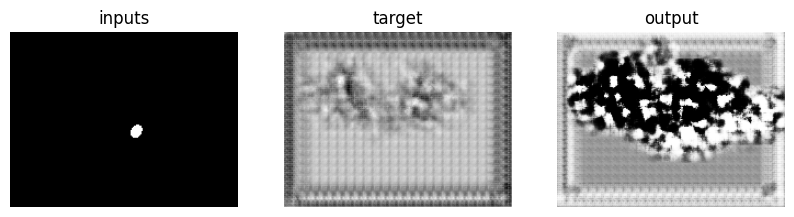

arr 0.70724607
norma 1.0
arr 0.99480045
norma 1.0
out_orev tensor([[[[[-11.1987, -10.8578, -12.2385,  ..., -26.5556, -32.6304,
            -20.7863],
           [-15.0115, -13.9756, -15.3664,  ..., -31.2354, -37.6266,
            -25.2240],
           [-15.4303, -17.7031, -17.1463,  ..., -29.4846, -35.0180,
            -26.3921],
           ...,
           [-20.2871, -18.8166, -21.3021,  ..., -29.3188, -35.5582,
            -20.5868],
           [-22.5638, -25.6197, -23.0182,  ..., -32.3397, -37.2230,
            -24.1978],
           [-15.8105, -16.7053, -16.2145,  ..., -21.3311, -23.3796,
            -13.6564]],

          [[-19.5842, -19.2876, -23.4994,  ..., -33.6790, -42.3451,
            -22.9503],
           [-19.7690, -25.1061, -21.8904,  ..., -37.9859, -35.7980,
            -24.3755],
           [-21.0859, -20.4702, -25.1017,  ..., -30.3872, -35.7950,
            -19.8925],
           ...,
           [-21.1595, -24.0861, -22.5357,  ..., -26.6643, -28.3425,
            -21.7434

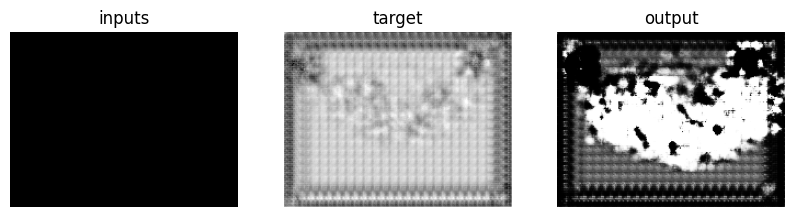

KeyboardInterrupt: 

In [ ]:
model_new.eval()  # Set the model to evaluation mode

# Create a DataLoader for validation or test data (assuming you have a 'val_dataloader' or 'test_dataloader')
predictions = []
true_labels = []
distances = []

for batch in val_dataloader:  # Use the appropriate DataLoader
    inputs, targets = batch[0].to(device), batch[1].to(device)
    # print(inputs.shape)
    # print(targets.shape)
    with torch.no_grad():
        outputs = model_new(inputs)
        
        out = nn.functional.softmax(outputs, dim = 1)
        print("out_orev",outputs)
        print("out",out)
        dist = compute_hausdorff_distance(out,targets)
        print(dist)
        plot_results(targets,outputs,out)
        distances.append(dist)
    predictions.append(outputs)  # Store model's predictions
    true_labels.append(targets)  # Store true labels

# Calculate evaluation metrics such as accuracy, F1 score, etc.
# Example: Calculate accuracy
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(true_labels, np.argmax(predictions, axis=1))

# print(f"Validation Accuracy: {accuracy}")


# UNETR


In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = UNETR(in_channels=1, out_channels=1, img_size=(112, 160, 208), feature_size=32, norm_name='batch')
model.to(device)

CUDA initialization: The NVIDIA driver on your system is too old (found version 11060). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)


UNETR(
  (vit): ViT(
    (patch_embedding): PatchEmbeddingBlock(
      (patch_embeddings): Conv3d(1, 768, kernel_size=(16, 16, 16), stride=(16, 16, 16))
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (blocks): ModuleList(
      (0-11): 12 x TransformerBlock(
        (mlp): MLPBlock(
          (linear1): Linear(in_features=768, out_features=3072, bias=True)
          (linear2): Linear(in_features=3072, out_features=768, bias=True)
          (fn): GELU(approximate='none')
          (drop1): Dropout(p=0.0, inplace=False)
          (drop2): Dropout(p=0.0, inplace=False)
        )
        (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SABlock(
          (out_proj): Linear(in_features=768, out_features=768, bias=True)
          (qkv): Linear(in_features=768, out_features=2304, bias=False)
          (input_rearrange): Rearrange('b h (qkv l d) -> qkv b l h d', qkv=3, l=12)
          (out_rearrange): Rearrange('b h l d -> b l (h d)')
          (drop_out

In [7]:
# loss_function = nn.BCELoss()
loss_function = DiceLoss(sigmoid=True, squared_pred=True)

optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [8]:
#plot 
import matplotlib.pyplot as plt
def plot_results(inputs,targets,outputs):
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))
    depth_slice = inputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_target = targets[:, :,22, :, :]  # Select the 128th slice along the depth dimension
    depth_slice_outputs = outputs[:, :, 22, :, :]  # Select the 128th slice along the depth dimension

    image_array = depth_slice[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_target = depth_slice_target[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch
    image_array_outputs = depth_slice_outputs[0].cpu().detach().numpy()  # Assuming you want to visualize the first image in the batch

    axes[0].imshow(image_array[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[0].set_title("inputs")
    axes[0].axis('off')  # Turn off axis labels


    axes[1].imshow(image_array_target[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[1].set_title("target")
    axes[1].axis('off')  # Turn off axis labels


    axes[2].imshow(image_array_outputs[0, :, :],cmap="gray")  # Assuming it's a grayscale image
    axes[2].set_title("output")
    axes[2].axis('off')  # Turn off axis labels

    plt.show()

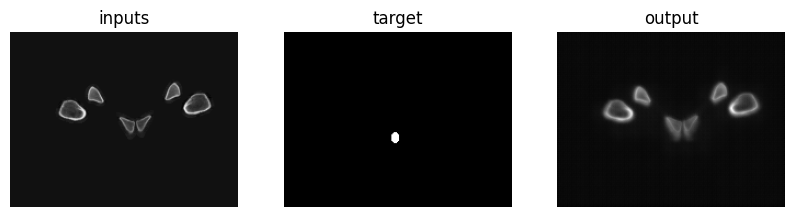

Epoch [1/100] - Loss: 0.9890947937965393


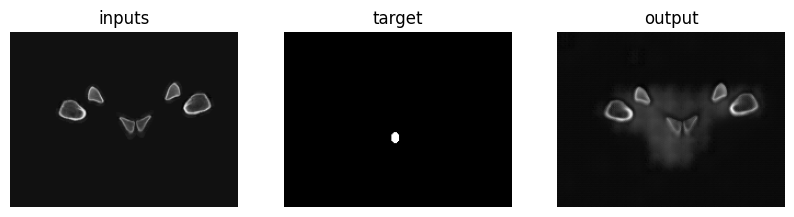

Epoch [2/100] - Loss: 0.9807679057121277


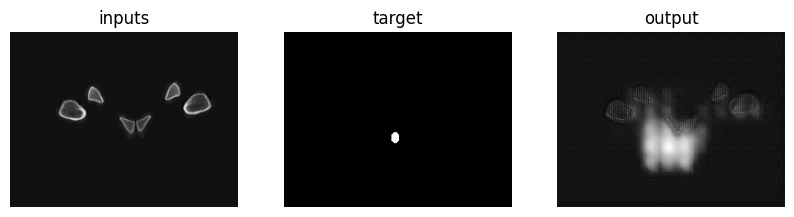

Epoch [3/100] - Loss: 0.9547080397605896


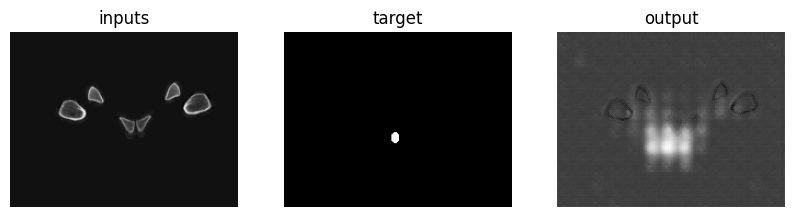

Epoch [4/100] - Loss: 0.9197209477424622


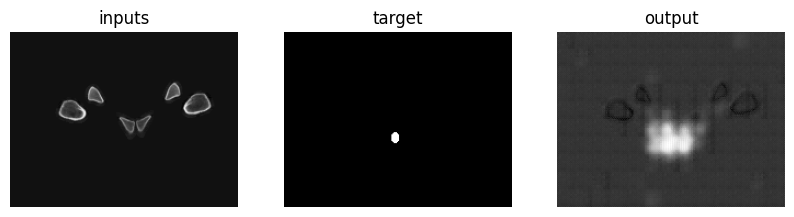

Epoch [5/100] - Loss: 0.8687440752983093


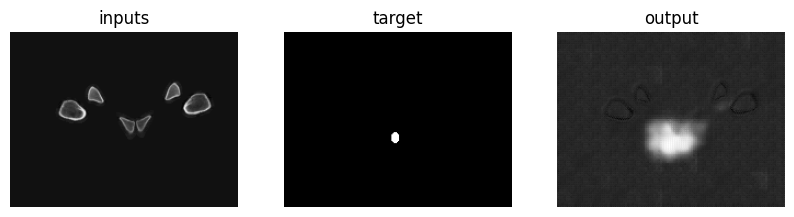

Epoch [6/100] - Loss: 0.8293676376342773


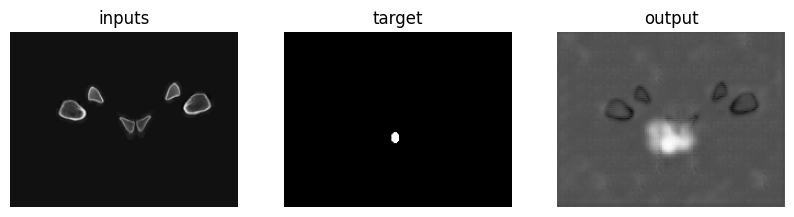

Epoch [7/100] - Loss: 0.7835075259208679


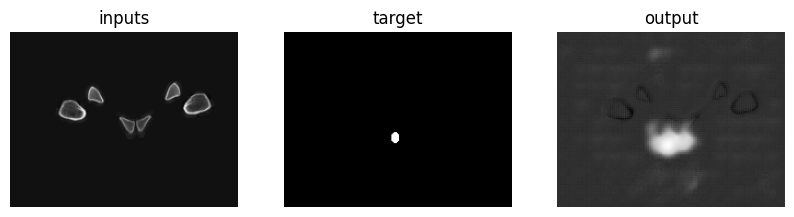

Epoch [8/100] - Loss: 0.7514848113059998


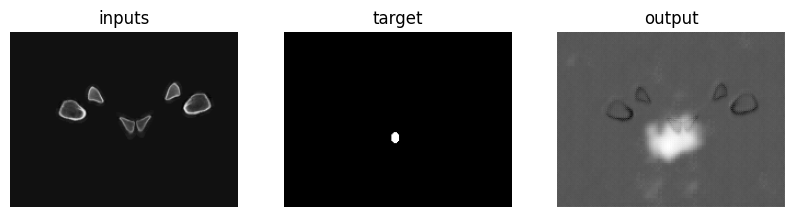

Epoch [9/100] - Loss: 0.7768771648406982


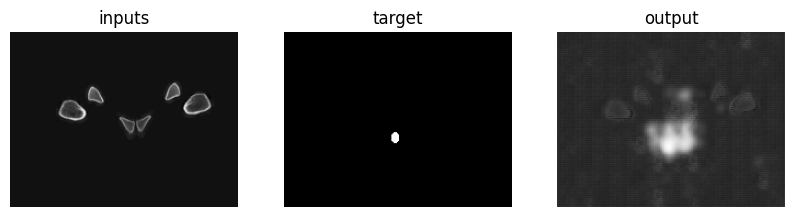

Epoch [10/100] - Loss: 0.7071650624275208


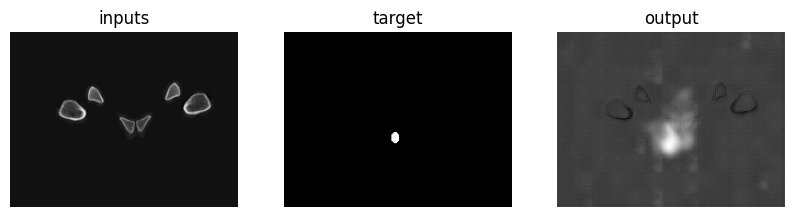

Epoch [11/100] - Loss: 0.7000148296356201


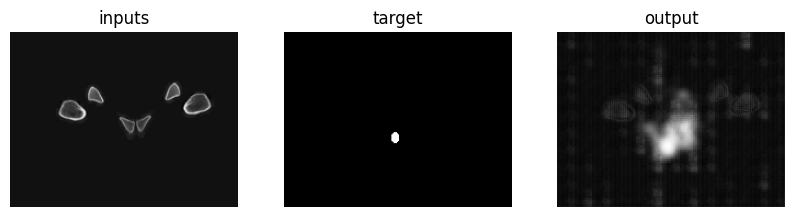

Epoch [12/100] - Loss: 0.6739487051963806


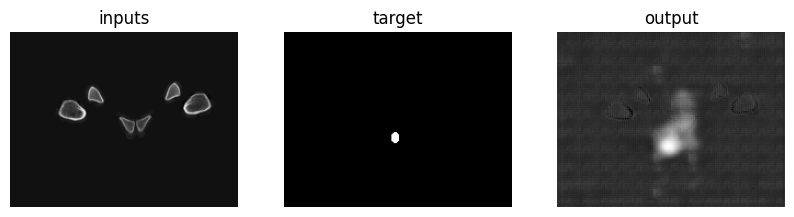

Epoch [13/100] - Loss: 0.6738686561584473


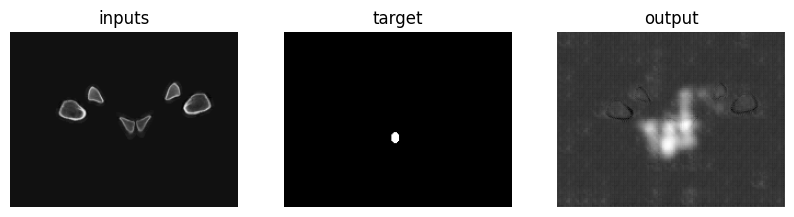

Epoch [14/100] - Loss: 0.6508083939552307


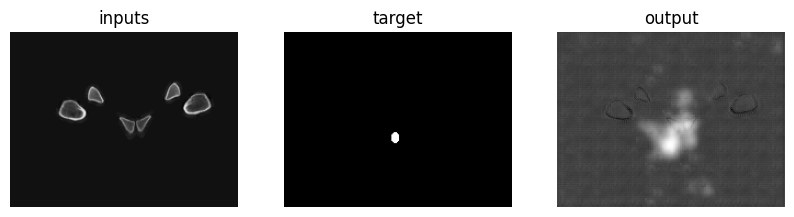

Epoch [15/100] - Loss: 0.6480659246444702


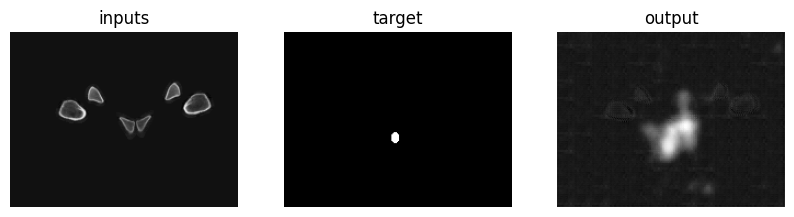

Epoch [16/100] - Loss: 0.6260784268379211


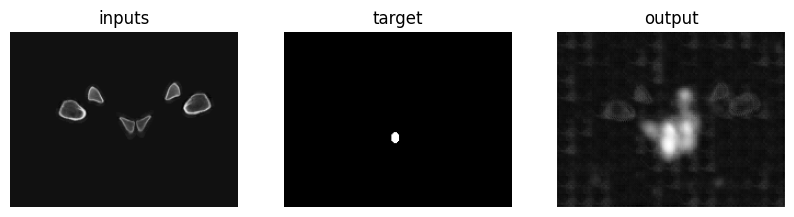

Epoch [17/100] - Loss: 0.6204085946083069


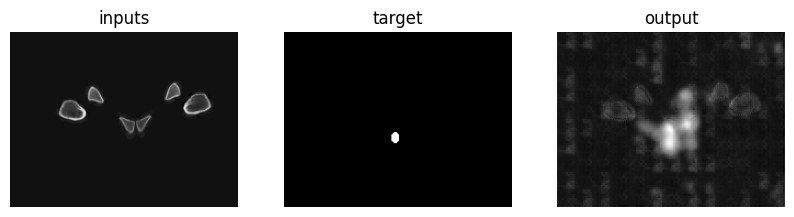

Epoch [18/100] - Loss: 0.5911670327186584


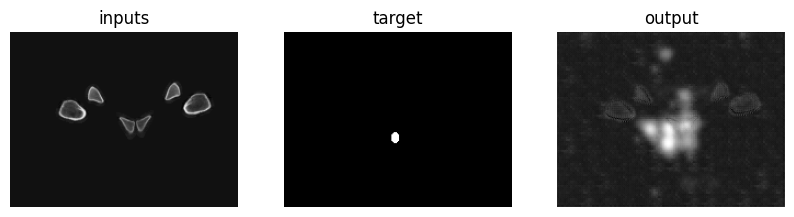

Epoch [19/100] - Loss: 0.602704644203186


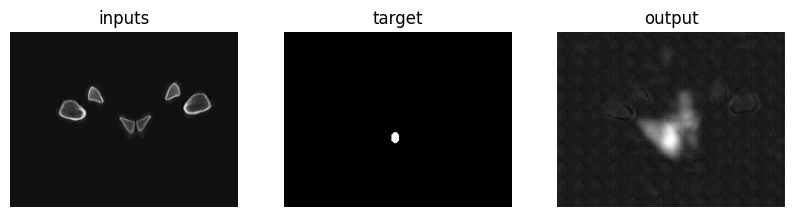

Epoch [20/100] - Loss: 0.5983719229698181


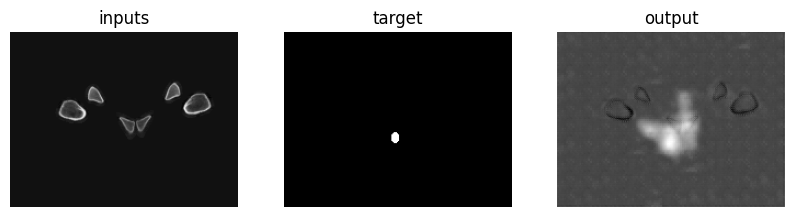

Epoch [21/100] - Loss: 0.5653321146965027


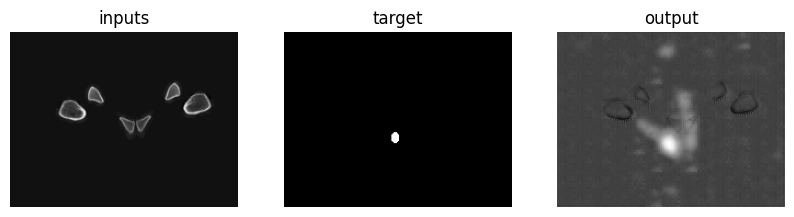

Epoch [22/100] - Loss: 0.5920112729072571


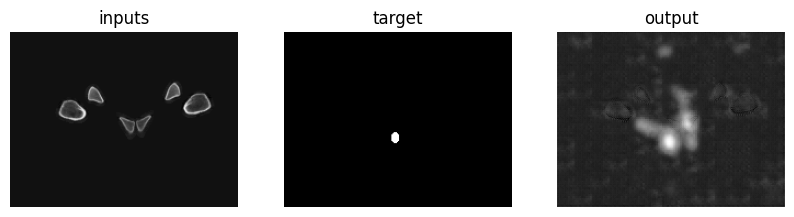

Epoch [23/100] - Loss: 0.5391367077827454


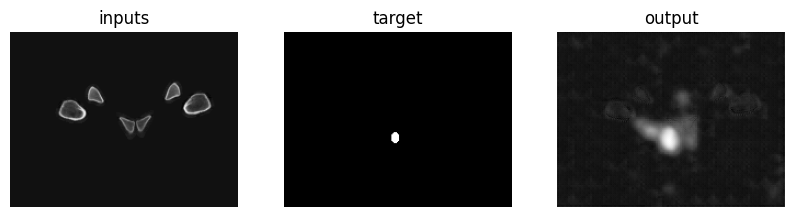

Epoch [24/100] - Loss: 0.5547356009483337


In [9]:
num_epochs = 100
loss_evolution = []

for epoch in range(num_epochs):
    
    model.train()
    for batch in train_dataloader:
        inputs, targets = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # out = nn.functional.softmax(outputs, dim = 0)
        
        loss = loss_function(outputs, targets)
        loss.backward()
        
        optimizer.step()
        
        # plot_results(inputs,targets,outputs)
    loss_evolution.append(loss)
    plot_results(inputs,targets,outputs)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {loss.item()}")

print("Training complete.")
